In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=8, color='darkgray', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=8, color='darkgray', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [10]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [11]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos confirmados COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [12]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
798353               2020-09-25           2020-09-24            2020-09-25   
798354               2020-09-25           2020-09-24            2020-09-25   
798355               2020-09-25           2020-09-24            2020-09-25   
798356               2020-09-25           2020-09-24            2020-09-25   
798357               2020-09-25           2020-06-21            2020-06-19   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                           2020-02-27            2020-03-13   
2                           2020-03-04            2020-03-19   
3                           2020-02-29            2020-03-15   
4                           2020-03-06            2020-03-26   
5                           2020-03-08            2020-03-23   
...                                ...                   ...   
798353                             NaT                   NaT   
798354                             NaT                   NaT   
798355                      2020-09-16                   NaT   
798356                             NaT                   NaT   
798357                      2020-06-17                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento  \
Id de caso                                                            
1                         NaT          Bogotá d.c.      Bogotá D.C.   
2                         NaT  Guadalajara de buga  Valle del Cauca   
3                         NaT             Medellín        Antioquia   
4                         NaT             Medellín        Antioquia   
5                         NaT             Medellín        Antioquia   
...                       ...                  ...              ...   
798353                    NaT          Bogotá d.c.      Bogotá D.C.   
798354                    NaT          Bogotá d.c.      Bogotá D.C.   
798355                    NaT          Bogotá d.c.      Bogotá D.C.   
798356                    NaT          Bogotá d.c.      Bogotá D.C.   
798357             2020-06-20              Soledad        Atlántico   

               Severidad      Estado  ...  Clasificación de edad Sexo  \
Id de caso                            ...                               
1                   Leve  Recuperado  ...                10 - 20    F   
2                   Leve  Recuperado  ...                30 - 40    M   
3                   Leve  Recuperado  ...                40 - 50    F   
4                   Leve  Recuperado  ...                50 - 60    M   
5                   Leve  Recuperado  ...                20 - 30    M   
...                  ...         ...  ...                    ...  ...   
798353      Asintomático        Casa  ...                30 - 40    F   
798354      Asintomático        Casa  ...                20 - 30    F   
798355          Moderado    Hospital  ...                10 - 20    F   
798356      Asintomático        Casa  ...                50 - 60    M   
798357         Fallecido   Fallecido  ...                60 - 70    M   

           Pertenecia Étnica Nombre Grupo Étnico         Tipo  \
Id de caso                                                      
1                       Otro                 NaN    Importado   
2                      Negro                 NaN    Importado   
3                       Otro 

### - TOP 50: Casos activos VS Ciudad de ubicación (Estado)

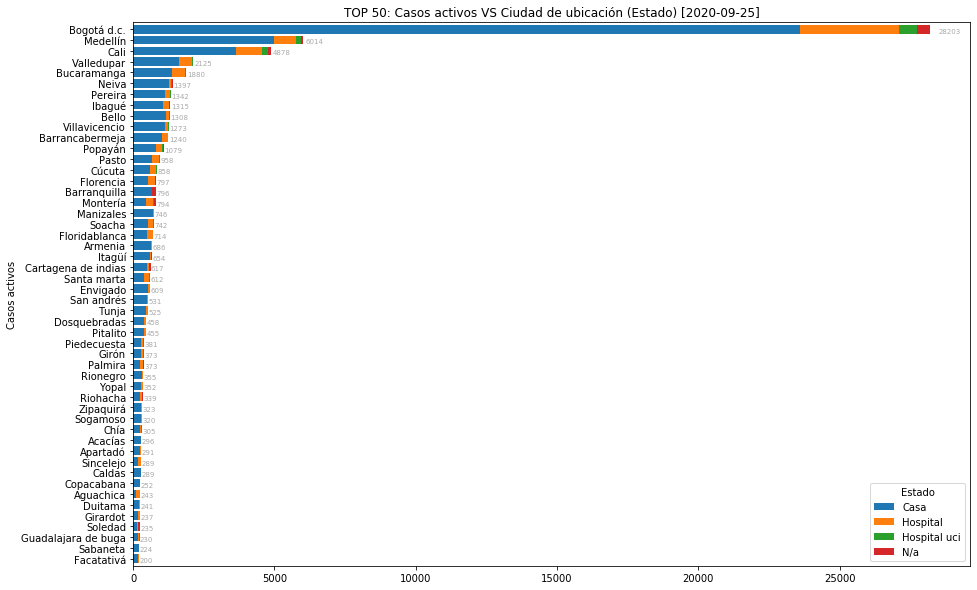

In [13]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'TOP 50: Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers_H(div)

In [14]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          23586.0    3526.0         638.0  453.0  28203.0
Medellín              4992.0     781.0         155.0   86.0   6014.0
Cali                  3638.0     938.0         198.0  104.0   4878.0
Valledupar            1625.0     449.0          36.0   15.0   2125.0
Bucaramanga           1370.0     450.0          41.0   19.0   1880.0
Neiva                 1264.0      68.0          56.0    9.0   1397.0
Pereira               1134.0     167.0          31.0   10.0   1342.0
Ibagué                1054.0     221.0          13.0   27.0   1315.0
Bello                 1171.0     111.0          17.0    9.0   1308.0
Villavicencio         1114.0     136.0           9.0   14.0   1273.0
Barrancabermeja       1019.0     199.0          14.0    8.0   1240.0
Popayán                794.0     232.0          40.0   13.0   1079.0
Pasto                  666.0     245.0          29.0   18.0    958.0
Cúcuta                 600.0     207.0          39.0   12.0    858.0
Florencia              528.0     245.0          12.0   12.0    797.0
Barranquilla           653.0      24.0           4.0  115.0    796.0
Montería               442.0     275.0          23.0   54.0    794.0
Manizales              691.0      43.0           2.0   10.0    746.0
Soacha                 541.0     176.0          15.0   10.0    742.0
Floridablanca          490.0     202.0          17.0    5.0    714.0
Armenia                618.0      64.0           3.0    1.0    686.0
Itagüí                 583.0      55.0           8.0    8.0    654.0
Cartagena de indias    502.0      65.0          11.0   39.0    617.0
Santa marta            374.0     196.0          19.0   23.0    612.0
Envigado               538.0      57.0          11.0    3.0    609.0
San andrés             504.0      23.0           3.0    1.0    531.0
Tunja                  456.0      60.0           3.0    6.0    525.0
Dosquebradas           376.0      71.0          10.0    1.0    458.0
Pitalito               403.0      37.0          10.0    5.0    455.0
Piedecuesta            279.0      88.0          12.0    2.0    381.0
Girón                  270.0      94.0           5.0    4.0    373.0
Palmira                250.0      98.0          17.0    8.0    373.0
Rionegro               302.0      45.0           5.0    3.0    355.0
Yopal                  271.0      75.0           5.0    1.0    352.0
Riohacha               234.0      91.0           8.0    6.0    339.0
Zipaquirá              292.0      22.0           5.0    4.0    323.0
Sogamoso               281.0      35.0           2.0    2.0    320.0
Chía                   253.0      42.0           6.0    4.0    305.0
Acacías                265.0      28.0           1.0    2.0    296.0
Apartadó               232.0      49.0           4.0    6.0    291.0
Caldas                 266.0      23.0           0.0    0.0    289.0
Sincelejo              179.0      84.0           8.0   18.0    289.0
Copacabana             236.0      12.0           2.0    2.0    252.0
Aguachica              100.0     133.0           9.0    1.0    243.0
Duitama                208.0      26.0           3.0    4.0    241.0
Girardot               182.0      49.0           6.0    0.0    237.0
Soledad                135.0      49.0           7.0   44.0    235.0
Guadalajara de buga    179.0      48.0           1.0    2.0    230.0
Sabaneta               208.0      15.0           0.0    1.0    224.0
Facatativá             161.0      31.0           7.0    1.0    200.0

### - Casos activos VS Departamento (Estado)

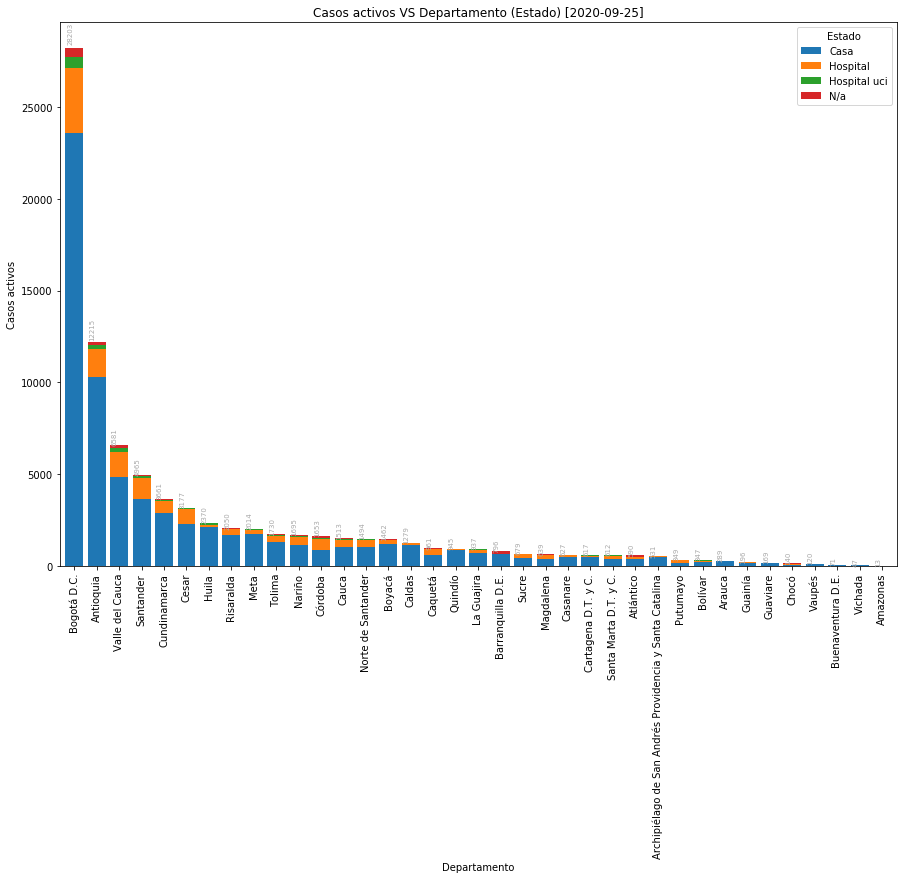

In [15]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [16]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         23586.0    3526.0   
Antioquia                                           10280.0    1523.0   
Valle del Cauca                                      4859.0    1333.0   
Santander                                            3661.0    1158.0   
Cundinamarca                                         2909.0     643.0   
Cesar                                                2314.0     778.0   
Huila                                                2106.0     152.0   
Risaralda                                            1714.0     281.0   
Meta                                                 1745.0     236.0   
Tolima                                               1286.0     375.0   
Nariño                                               1151.0     456.0   
Córdoba                                               874.0     617.0   
Cauca                                                1012.0     399.0   
Norte de Santander                                   1048.0     352.0   
Boyacá                                               1203.0     230.0   
Caldas                                               1124.0     124.0   
Caquetá                                               618.0     306.0   
Quindío                                               853.0      87.0   
La Guajira                                            684.0     214.0   
Barranquilla D.E.                                     653.0      24.0   
Sucre                                                 426.0     209.0   
Magdalena                                             404.0     180.0   
Casanare                                              502.0     113.0   
Cartagena D.T. y C.                                   502.0      65.0   
Santa Marta D.T. y C.                                 374.0     196.0   
Atlántico                                             382.0      88.0   
Archipiélago de San Andrés Providencia y Santa ...    504.0      23.0   
Putumayo                                              149.0     189.0   
Bolívar                                               215.0      85.0   
Arauca                                                263.0      19.0   
Guainía                                               180.0      16.0   
Guaviare                                              159.0       4.0   
Chocó                                                  74.0      49.0   
Vaupés                                                103.0      15.0   
Buenaventura D.E.                                      36.0      23.0   
Vichada                                                42.0       4.0   
Amazonas                                                4.0       5.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                638.0  453.0   
Antioquia                                                  245.0  167.0   
Valle del Cauca                                            248.0  141.0   
Santander                                                   98.0   48.0   
Cundinamarca                                                65.0   44.0   
Cesar                                                       58.0   27.0   
Huila                                                       90.0   22.0   
Risaralda                                                   42.0   13.0   
Meta                                                        12.0   21.0   
Tolima                                                      27.0   42.0   
Nariño                                                      47.0   41.0   
Córdoba                                                     48.0  114.0   
Cauca                                                       73.0   29.0   
Norte de Santander         

### - Casos confirmados VS Departamento (Estado)

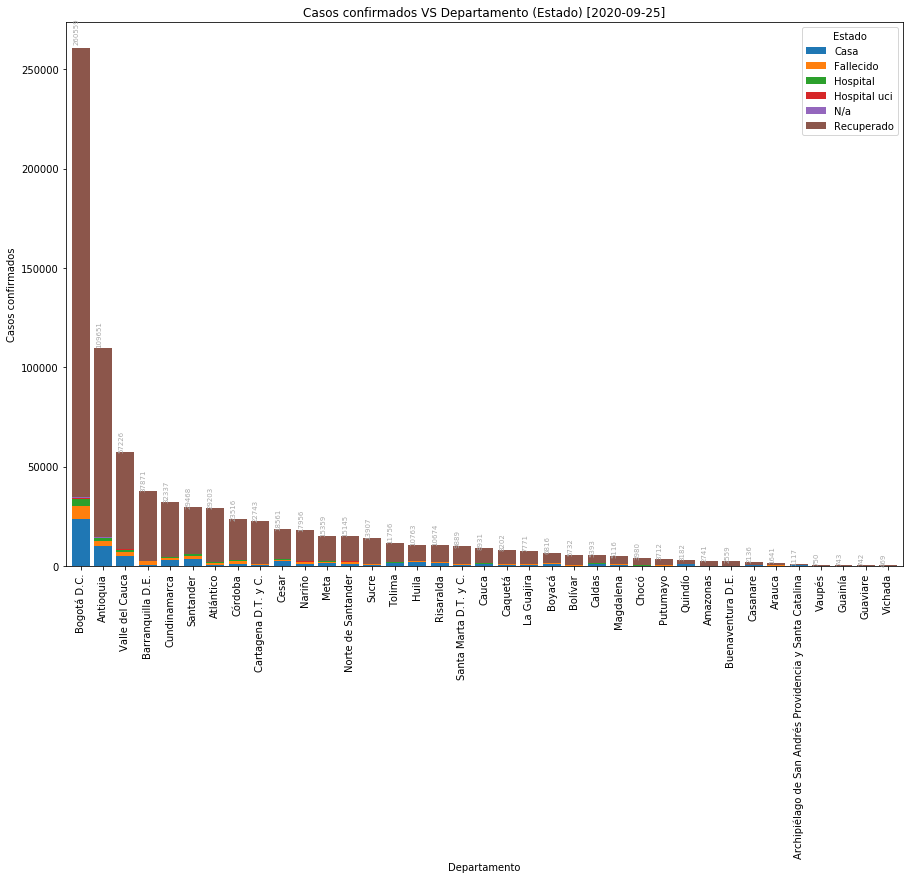

In [17]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [18]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         23586.0     6650.0   
Antioquia                                           10280.0     2296.0   
Valle del Cauca                                      4859.0     2023.0   
Barranquilla D.E.                                     653.0     1670.0   
Cundinamarca                                         2909.0      952.0   
Santander                                            3661.0     1236.0   
Atlántico                                             382.0     1383.0   
Córdoba                                               874.0     1511.0   
Cartagena D.T. y C.                                   502.0      544.0   
Cesar                                                2314.0      546.0   
Nariño                                               1151.0      668.0   
Meta                                                 1745.0      392.0   
Norte de Santander                                   1048.0      868.0   
Sucre                                                 426.0      570.0   
Tolima                                               1286.0      308.0   
Huila                                                2106.0      324.0   
Risaralda                                            1714.0      231.0   
Santa Marta D.T. y C.                                 374.0      429.0   
Cauca                                                1012.0      246.0   
Caquetá                                               618.0      284.0   
La Guajira                                            684.0      291.0   
Boyacá                                               1203.0      133.0   
Bolívar                                               215.0      220.0   
Caldas                                               1124.0      120.0   
Magdalena                                             404.0      383.0   
Chocó                                                  74.0      155.0   
Putumayo                                              149.0      167.0   
Quindío                                               853.0       90.0   
Amazonas                                                4.0      117.0   
Buenaventura D.E.                                      36.0      166.0   
Casanare                                              502.0       43.0   
Arauca                                                263.0       41.0   
Archipiélago de San Andrés Providencia y Santa ...    504.0       11.0   
Vaupés                                                103.0        8.0   
Guainía                                               180.0       11.0   
Guaviare                                              159.0       12.0   
Vichada                                                42.0        4.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           3526.0         638.0   
Antioquia                                             1523.0         245.0   
Valle del Cauca                                       1333.0         248.0   
Barranquilla D.E.                                       24.0           4.0   
Cundinamarca                                           643.0          65.0   
Santander                                             1158.0          98.0   
Atlántico                                               88.0          21.0   
Córdoba                                                617.0          48.0   
Cartagena D.T. y C.                                     65.0          11.0   
Cesar                                                  778.0          58.0   
Nariño                                                 456.0          47.0   
Meta                                                   236.0          12.0   
Norte de Santander   

### - Casos confirmados VS Departamento (Sexo)

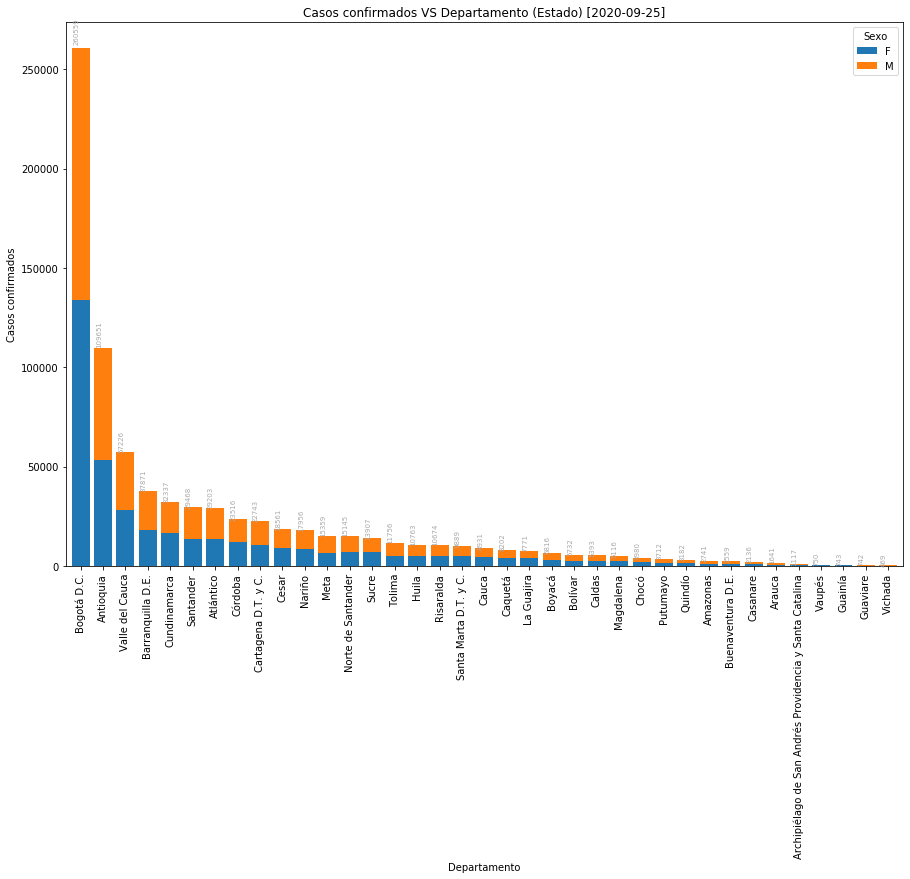

In [19]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [20]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         133734  126825  260559
Antioquia                                            53505   56146  109651
Valle del Cauca                                      27982   29244   57226
Barranquilla D.E.                                    17974   19897   37871
Cundinamarca                                         16459   15878   32337
Santander                                            13404   16064   29468
Atlántico                                            13856   15347   29203
Córdoba                                              12213   11303   23516
Cartagena D.T. y C.                                  10668   12075   22743
Cesar                                                 9128    9433   18561
Nariño                                                8791    9165   17956
Meta                                                  6332    9027   15359
Norte de Santander                                    7100    8045   15145
Sucre                                                 6892    7015   13907
Tolima                                                4892    6864   11756
Huila                                                 5195    5568   10763
Risaralda                                             5210    5464   10674
Santa Marta D.T. y C.                                 4978    4911    9889
Cauca                                                 4449    4482    8931
Caquetá                                               4056    4146    8202
La Guajira                                            4017    3754    7771
Boyacá                                                3235    3581    6816
Bolívar                                               2727    3005    5732
Caldas                                                2605    2788    5393
Magdalena                                             2607    2509    5116
Chocó                                                 1896    2084    3980
Putumayo                                              1727    1985    3712
Quindío                                               1565    1617    3182
Amazonas                                              1182    1559    2741
Buenaventura D.E.                                      944    1615    2559
Casanare                                               888    1248    2136
Arauca                                                 646     995    1641
Archipiélago de San Andrés Providencia y Santa ...     575     542    1117
Vaupés                                                 337     413     750
Guainía                                                352     391     743
Guaviare                                               276     466     742
Vichada                                                169     300     469

### - Recuperados y Fallecidos VS Departamento

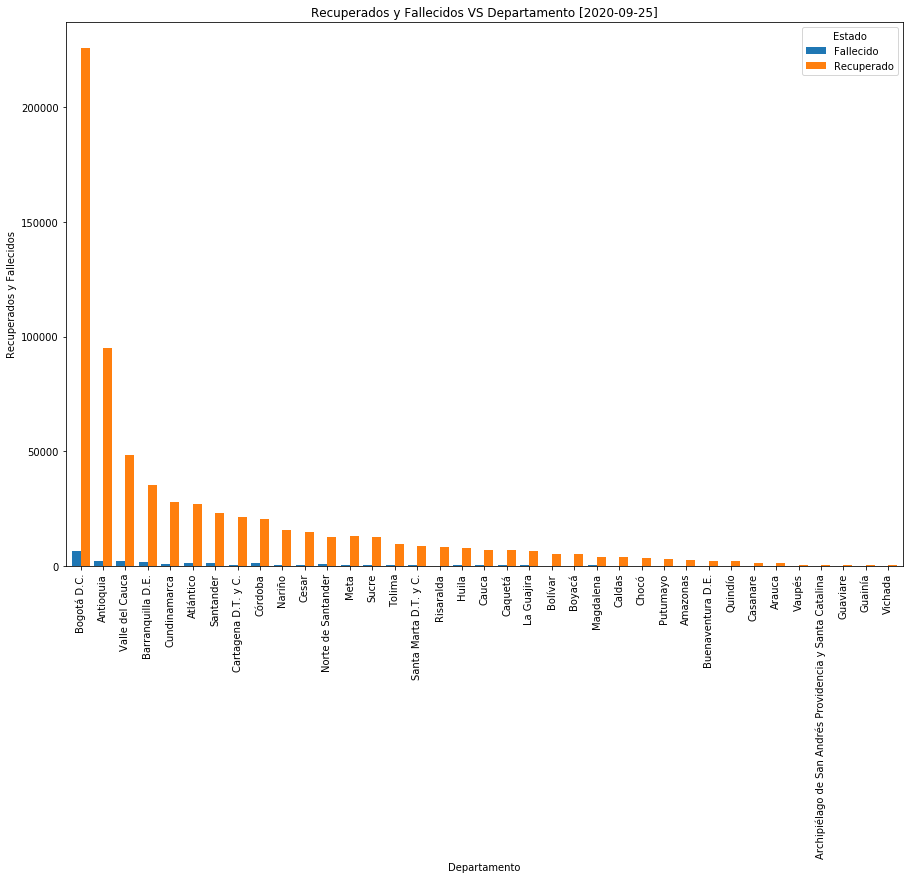

In [21]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [22]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            6650.0    225706.0
Antioquia                                              2296.0     95140.0
Valle del Cauca                                        2023.0     48622.0
Barranquilla D.E.                                      1670.0     35405.0
Cundinamarca                                            952.0     27724.0
Atlántico                                              1383.0     27230.0
Santander                                              1236.0     23267.0
Cartagena D.T. y C.                                     544.0     21582.0
Córdoba                                                1511.0     20352.0
Nariño                                                  668.0     15593.0
Cesar                                                   546.0     14838.0
Norte de Santander                                      868.0     12783.0
Meta                                                    392.0     12953.0
Sucre                                                   570.0     12658.0
Tolima                                                  308.0      9718.0
Santa Marta D.T. y C.                                   429.0      8848.0
Risaralda                                               231.0      8393.0
Huila                                                   324.0      8069.0
Cauca                                                   246.0      7172.0
Caquetá                                                 284.0      6957.0
La Guajira                                              291.0      6543.0
Bolívar                                                 220.0      5165.0
Boyacá                                                  133.0      5221.0
Magdalena                                               383.0      4094.0
Caldas                                                  120.0      3994.0
Chocó                                                   155.0      3685.0
Putumayo                                                167.0      3196.0
Amazonas                                                117.0      2611.0
Buenaventura D.E.                                       166.0      2322.0
Quindío                                                  90.0      2147.0
Casanare                                                 43.0      1466.0
Arauca                                                   41.0      1311.0
Vaupés                                                    8.0       622.0
Archipiélago de San Andrés Providencia y Santa ...       11.0       575.0
Guaviare                                                 12.0       561.0
Guainía                                                  11.0       536.0
Vichada                                                   4.0       418.0

* Fallecimientos relacionados al COVID-19.

### - Mapa de influencia COVID-19 (Colombia)

In [23]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos confirmados COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

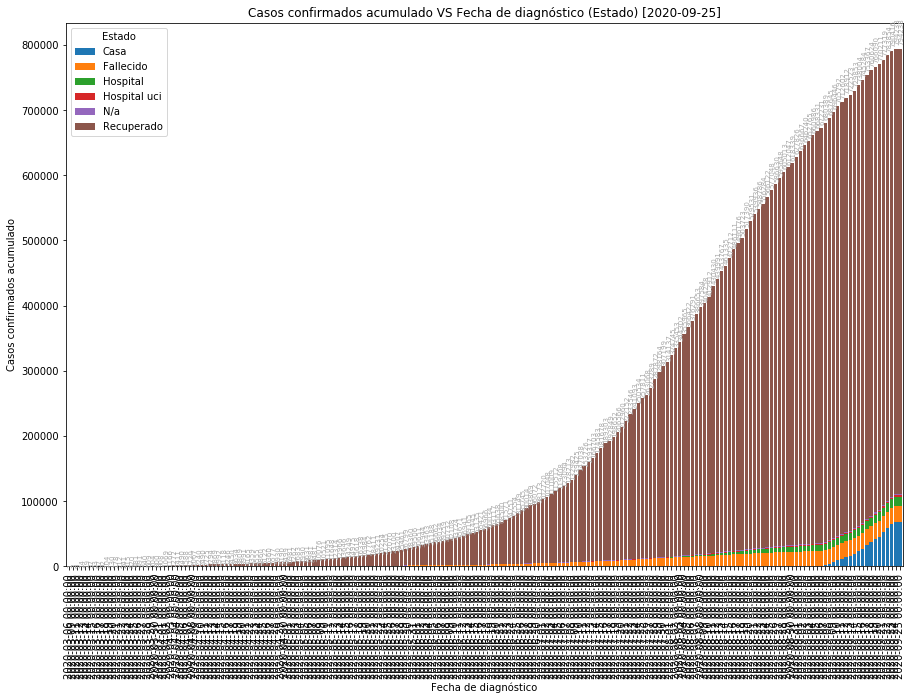

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                       
2020-09-25            67966.0    24890.0   14090.0        1973.0  1638.0   
2020-09-24            67962.0    24889.0   14090.0        1973.0  1638.0   
2020-09-23            64359.0    24889.0   13890.0        1959.0  1638.0   
2020-09-22            58190.0    24855.0   13546.0        1944.0  1638.0   
2020-09-21            52118.0    24811.0   13145.0        1929.0  1637.0   
2020-09-20            45410.0    24764.0   12877.0        1925.0  1634.0   
2020-09-19            41588.0    24726.0   12682.0        1918.0  1633.0   
2020-09-18            36941.0    24666.0   12460.0        1906.0  1631.0   
2020-09-17            32386.0    24588.0   12148.0        1886.0  1624.0   
2020-09-16            27111.0    24508.0   11802.0        1867.0  1614.0   
2020-09-15            22740.0    24394.0   11474.0        1840.0  1608.0   
2020-09-14            19403.0    24295.0   11238.0        1808.0  1602.0   
2020-09-13            15950.0    24174.0   10996.0        1771.0  1592.0   
2020-09-12            14549.0    24125.0   10856.0        1754.0  1587.0   
2020-09-11            11861.0    24003.0   10651.0        1727.0  1579.0   
2020-09-10             9115.0    23868.0   10403.0        1693.0  1570.0   
2020-09-09             5984.0    23714.0   10060.0        1651.0  1560.0   
2020-09-08             3384.0    23542.0    9745.0        1617.0  1551.0   
2020-09-07             1537.0    23403.0    9513.0        1566.0  1547.0   
2020-09-06              449.0    23236.0    9268.0        1537.0  1536.0   
2020-09-05              301.0    23151.0    9145.0        1519.0  1535.0   
2020-09-04              195.0    22986.0    8777.0        1487.0  1527.0   
2020-09-03              144.0    22824.0    8610.0        1439.0  1512.0   
2020-09-02              125.0    22678.0    8413.0        1413.0  1505.0   
2020-09-01              112.0    22377.0    8216.0        1373.0  1489.0   
2020-08-31               93.0    22184.0    8038.0        1343.0  1481.0   
2020-08-30               85.0    21950.0    7760.0        1307.0  1471.0   
2020-08-29               80.0    21797.0    7557.0        1279.0  1456.0   
2020-08-28               79.0    21608.0    7351.0        1256.0  1449.0   
2020-08-27               73.0    21351.0    7047.0        1203.0  1440.0   
2020-08-26               67.0    21104.0    6771.0        1172.0  1427.0   
2020-08-25               55.0    20798.0    6508.0        1138.0  1415.0   
2020-08-24               43.0    20526.0    6229.0        1099.0  1402.0   
2020-08-23               34.0    20215.0    5936.0        1068.0  1385.0   
2020-08-22               32.0    20029.0    5723.0        1055.0  1376.0   
2020-08-21               30.0    19756.0    5372.0        1043.0  1362.0   
2020-08-20               30.0    19452.0    5038.0        1016.0  1339.0   
2020-08-19               28.0    19005.0    4608.0         975.0  1318.0   
2020-08-18               25.0    18647.0    4264.0         935.0  1298.0   
2020-08-17               21.0    18371.0    4031.0         920.0  1273.0   
2020-08-16               20.0    18154.0    3820.0         898.0  1258.0   
2020-08-15               20.0    17833.0    3505.0         871.0  1245.0   
2020-08-14               18.0    17516.0    3200.0         849.0  1233.0   
2020-08-13               14.0    17258.0    3022.0         837.0  1222.0   
2020-08-12                7.0    16920.0    2691.0         806.0  1200.0   
2020-08-11                6.0    16534.0    2401.0         780.0  1186.0   
2020-08-10                4.0    16097.0    1957.0         733.0  1158.0   
2020-08-09                3.0    15858.0    1719.0         712.0  1137.0   
2020-08-08                3.0    15619.0    1522.0         691.0  1127.0   
2020-08-07                3.0    15273.0    1329.0         658.0  1106.0   
2020-08-06                3.0    14968.0    1111

### - Casos confirmados VS Fecha de diagnóstico (Estado)

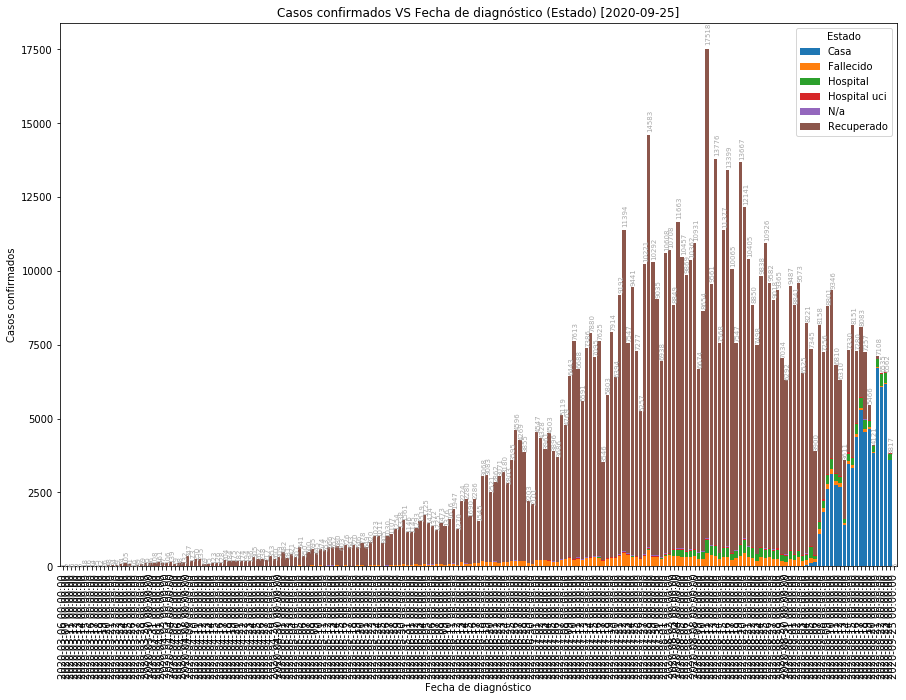

In [26]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [27]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-09-25               4.0        1.0       0.0           0.0   0.0   
2020-09-24            3603.0        0.0     200.0          14.0   0.0   
2020-09-23            6169.0       34.0     344.0          15.0   0.0   
2020-09-22            6072.0       44.0     401.0          15.0   1.0   
2020-09-21            6708.0       47.0     268.0           4.0   3.0   
2020-09-20            3822.0       38.0     195.0           7.0   1.0   
2020-09-19            4647.0       60.0     222.0          12.0   2.0   
2020-09-18            4555.0       78.0     312.0          20.0   7.0   
2020-09-17            5275.0       80.0     346.0          19.0  10.0   
2020-09-16            4371.0      114.0     328.0          27.0   6.0   
2020-09-15            3337.0       99.0     236.0          32.0   6.0   
2020-09-14            3453.0      121.0     242.0          37.0  10.0   
2020-09-13            1401.0       49.0     140.0          17.0   5.0   
2020-09-12            2688.0      122.0     205.0          27.0   8.0   
2020-09-11            2746.0      135.0     248.0          34.0   9.0   
2020-09-10            3131.0      154.0     343.0          42.0  10.0   
2020-09-09            2600.0      172.0     315.0          34.0   9.0   
2020-09-08            1847.0      139.0     232.0          51.0   4.0   
2020-09-07            1088.0      167.0     245.0          29.0  11.0   
2020-09-06             148.0       85.0     123.0          18.0   1.0   
2020-09-05             106.0      165.0     368.0          32.0   8.0   
2020-09-04              51.0      162.0     167.0          48.0  15.0   
2020-09-03              19.0      146.0     197.0          26.0   7.0   
2020-09-02              13.0      301.0     197.0          40.0  16.0   
2020-09-01              19.0      193.0     178.0          30.0   8.0   
2020-08-31               8.0      234.0     278.0          36.0  10.0   
2020-08-30               5.0      153.0     203.0          28.0  15.0   
2020-08-29               1.0      189.0     206.0          23.0   7.0   
2020-08-28               6.0      257.0     304.0          53.0   9.0   
2020-08-27               6.0      247.0     276.0          31.0  13.0   
2020-08-26              12.0      306.0     263.0          34.0  12.0   
2020-08-25              12.0      272.0     279.0          39.0  13.0   
2020-08-24               9.0      311.0     293.0          31.0  17.0   
2020-08-23               2.0      186.0     213.0          13.0   9.0   
2020-08-22               2.0      273.0     351.0          12.0  14.0   
2020-08-21               0.0      304.0     334.0          27.0  23.0   
2020-08-20               2.0      447.0     430.0          41.0  21.0   
2020-08-19               3.0      358.0     344.0          40.0  20.0   
2020-08-18               4.0      276.0     233.0          15.0  25.0   
2020-08-17               1.0      217.0     211.0          22.0  15.0   
2020-08-16               0.0      321.0     315.0          27.0  13.0   
2020-08-15               2.0      317.0     305.0          22.0  12.0   
2020-08-14               4.0      258.0     178.0          12.0  11.0   
2020-08-13               7.0      338.0     331.0          31.0  22.0   
2020-08-12               1.0      386.0     290.0          26.0  14.0   
2020-08-11               2.0      437.0     444.0          47.0  28.0   
2020-08-10               1.0      239.0     238.0          21.0  21.0   
2020-08-09               0.0      239.0     197.0          21.0  10.0   
2020-08-08               0.0      346.0     193.0          33.0  21.0   
2020-08-07               0.0      305.0     218.0          42.0  23.0   
2020-08-06               0.0      301.0     172.0          29.0  25.0   
2020-08-05               1.0      307.0     235.0          33.0  28.0   
2020-08-04               0.0      348.0     213.0         

### - Casos confirmados VS Clasificación de edad (Estado)

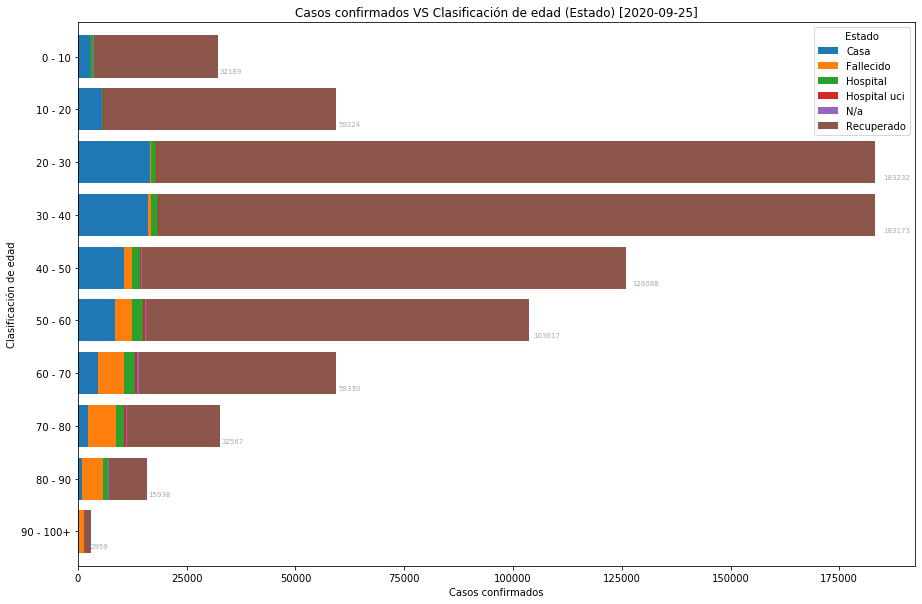

In [28]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [29]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  2777         41       699            51   38   
10 - 20                 5440         44       388            16   32   
20 - 30                16525        316      1150            76   68   
30 - 40                16015        800      1616           181   65   
40 - 50                10671       1764      1887           266  120   
50 - 60                 8612       3706      2696           480  198   
60 - 70                 4541       6004      2650           481  364   
70 - 80                 2228       6489      1912           311  384   
80 - 90                 1010       4841       961           106  322   
90 - 100+                180       1098       138             9   73   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      28583  
10 - 20                     53304  
20 - 30                    165097  
30 - 40                    164496  
40 - 50                    111380  
50 - 60                     87925  
60 - 70                     45290  
70 - 80                     21243  
80 - 90                      8698  
90 - 100+                    1461

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

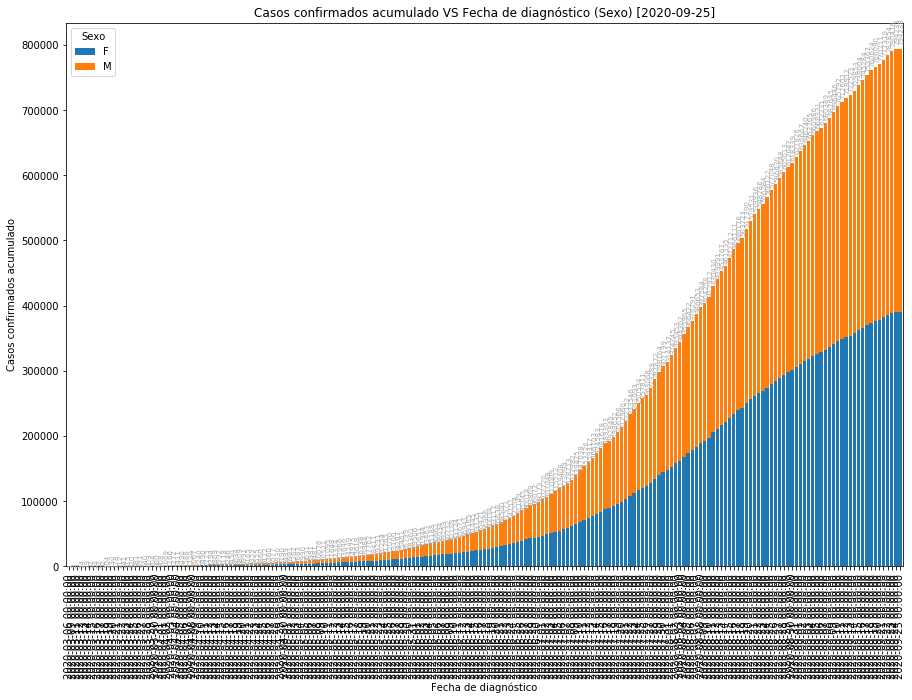

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-09-25            390619.0  403619.0
2020-09-24            390617.0  403616.0
2020-09-23            388701.0  401715.0
2020-09-22            385363.0  398491.0
2020-09-21            382009.0  395310.0
2020-09-20            378365.0  391846.0
2020-09-19            376203.0  389887.0
2020-09-18            373549.0  387075.0
2020-09-17            369770.0  383597.0
2020-09-16            365769.0  379515.0
2020-09-15            362046.0  375958.0
2020-09-14            357780.0  372073.0
2020-09-13            354029.0  368494.0
2020-09-12            352192.0  366720.0
2020-09-11            348864.0  363738.0
2020-09-10            345242.0  360550.0
2020-09-09            340468.0  355978.0
2020-09-08            335976.0  351669.0
2020-09-07            332272.0  348117.0
2020-09-06            328042.0  344189.0
2020-09-05            326043.0  342288.0
2020-09-04            322573.0  338413.0
2020-09-03            318155.0  334610.0
2020-09-02            314819.0  331421.0
2020-09-01            309935.0  326732.0
2020-08-31            305510.0  322316.0
2020-08-30            300510.0  317829.0
2020-08-29            297321.0  314726.0
2020-08-28            293757.0  311256.0
2020-08-27            289052.0  306596.0
2020-08-26            284500.0  302130.0
2020-08-25            279616.0  297432.0
2020-08-24            274130.0  291992.0
2020-08-23            269224.0  287060.0
2020-08-22            265429.0  283357.0
2020-08-21            261257.0  278679.0
2020-08-20            256010.0  273521.0
2020-08-19            249891.0  267499.0
2020-08-18            242757.0  260966.0
2020-08-17            239112.0  257064.0
2020-08-16            233801.0  252310.0
2020-08-15            226790.0  245922.0
2020-08-14            221016.0  240319.0
2020-08-13            217140.0  236627.0
2020-08-12            210252.0  229739.0
2020-08-11            205514.0  224916.0
2020-08-10            196437.0  216475.0
2020-08-09            192094.0  212164.0
2020-08-08            188648.0  208936.0
2020-08-07            183324.0  203329.0
2020-08-06            178262.0  198029.0
2020-08-05            173375.0  193047.0
2020-08-04            168142.0  187823.0
2020-08-03            162289.0  182013.0
2020-08-02            158009.0  177444.0
2020-08-01            152536.0  172209.0
2020-07-31            147402.0  166735.0
2020-07-30            143929.0  163270.0
2020-07-29            139534.0  158630.0
2020-07-28            134435.0  153437.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

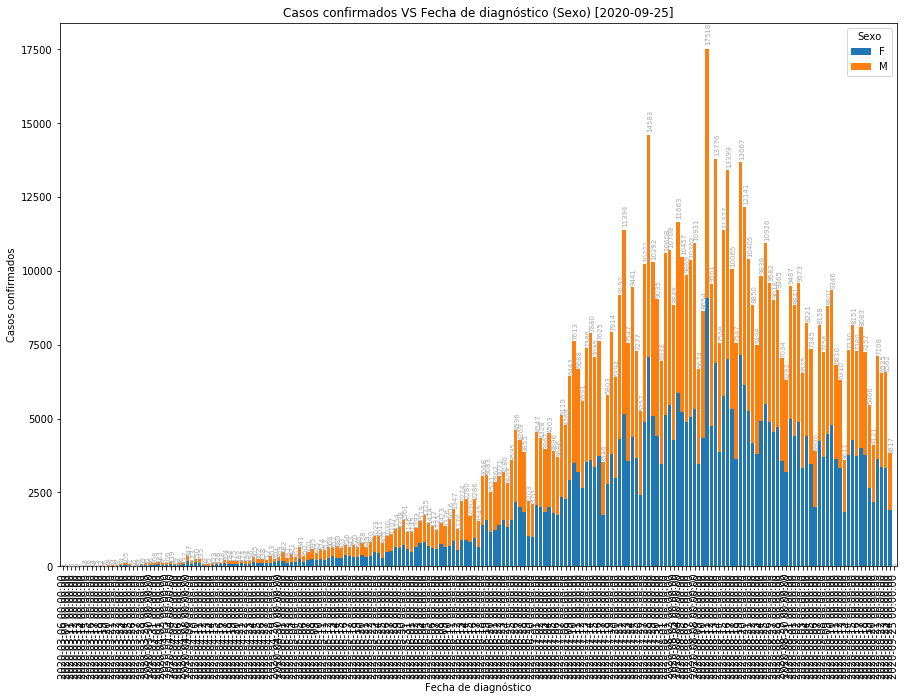

In [32]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [33]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-09-25               2.0     3.0
2020-09-24            1916.0  1901.0
2020-09-23            3338.0  3224.0
2020-09-22            3354.0  3181.0
2020-09-21            3644.0  3464.0
2020-09-20            2162.0  1959.0
2020-09-19            2654.0  2812.0
2020-09-18            3779.0  3478.0
2020-09-17            4001.0  4082.0
2020-09-16            3723.0  3557.0
2020-09-15            4266.0  3885.0
2020-09-14            3751.0  3579.0
2020-09-13            1837.0  1774.0
2020-09-12            3328.0  2982.0
2020-09-11            3622.0  3188.0
2020-09-10            4774.0  4572.0
2020-09-09            4492.0  4309.0
2020-09-08            3704.0  3552.0
2020-09-07            4230.0  3928.0
2020-09-06            1999.0  1901.0
2020-09-05            3470.0  3875.0
2020-09-04            4418.0  3803.0
2020-09-03            3336.0  3189.0
2020-09-02            4884.0  4689.0
2020-09-01            4425.0  4416.0
2020-08-31            5000.0  4487.0
2020-08-30            3189.0  3103.0
2020-08-29            3564.0  3470.0
2020-08-28            4705.0  4660.0
2020-08-27            4552.0  4466.0
2020-08-26            4884.0  4698.0
2020-08-25            5486.0  5440.0
2020-08-24            4906.0  4932.0
2020-08-23            3795.0  3703.0
2020-08-22            4172.0  4678.0
2020-08-21            5247.0  5158.0
2020-08-20            6119.0  6022.0
2020-08-19            7134.0  6533.0
2020-08-18            3645.0  3902.0
2020-08-17            5311.0  4754.0
2020-08-16            7011.0  6388.0
2020-08-15            5774.0  5603.0
2020-08-14            3876.0  3692.0
2020-08-13            6888.0  6888.0
2020-08-12            4738.0  4823.0
2020-08-11            9077.0  8441.0
2020-08-10            4343.0  4311.0
2020-08-09            3446.0  3228.0
2020-08-08            5324.0  5607.0
2020-08-07            5062.0  5300.0
2020-08-06            4887.0  4982.0
2020-08-05            5233.0  5224.0
2020-08-04            5853.0  5810.0
2020-08-03            4280.0  4569.0
2020-08-02            5473.0  5235.0
2020-08-01            5134.0  5474.0
2020-07-31            3473.0  3465.0
2020-07-30            4395.0  4640.0
2020-07-29            5099.0  5193.0
2020-07-28            7099.0  7484.0

### - Casos confirmados VS Clasificación de edad (Sexo)

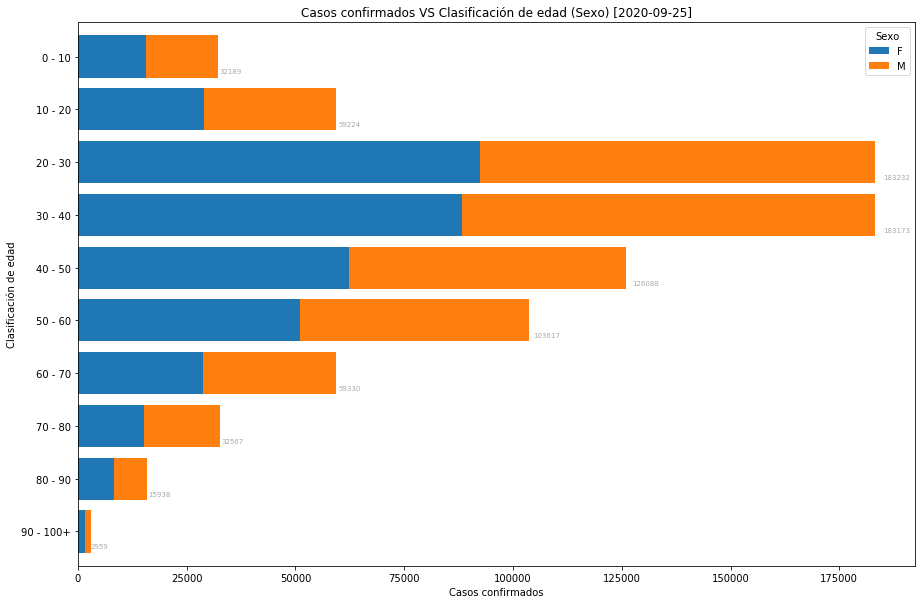

In [34]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                 15688  16501
10 - 20                28934  30290
20 - 30                92435  90797
30 - 40                88342  94831
40 - 50                62400  63688
50 - 60                50975  52642
60 - 70                28690  30640
70 - 80                15259  17308
80 - 90                 8175   7763
90 - 100+               1668   1291

### - Casos confirmados VS Estado (Sexo)

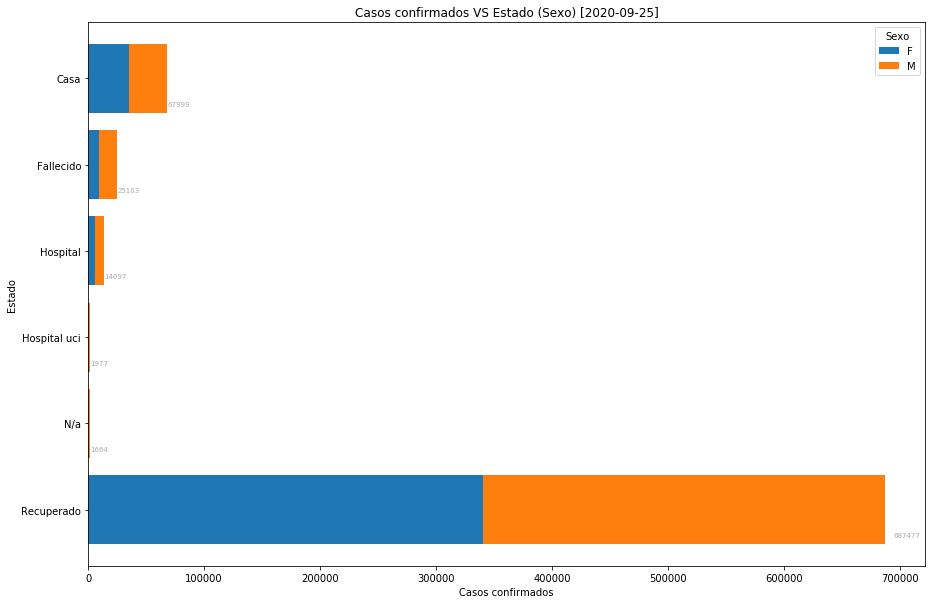

In [36]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           35130   32869
Fallecido       9018   16085
Hospital        6097    8000
Hospital uci     658    1319
N/a              720     944
Recuperado    340943  346534

### - Casos confirmados VS Tipo de contagio (Sexo)

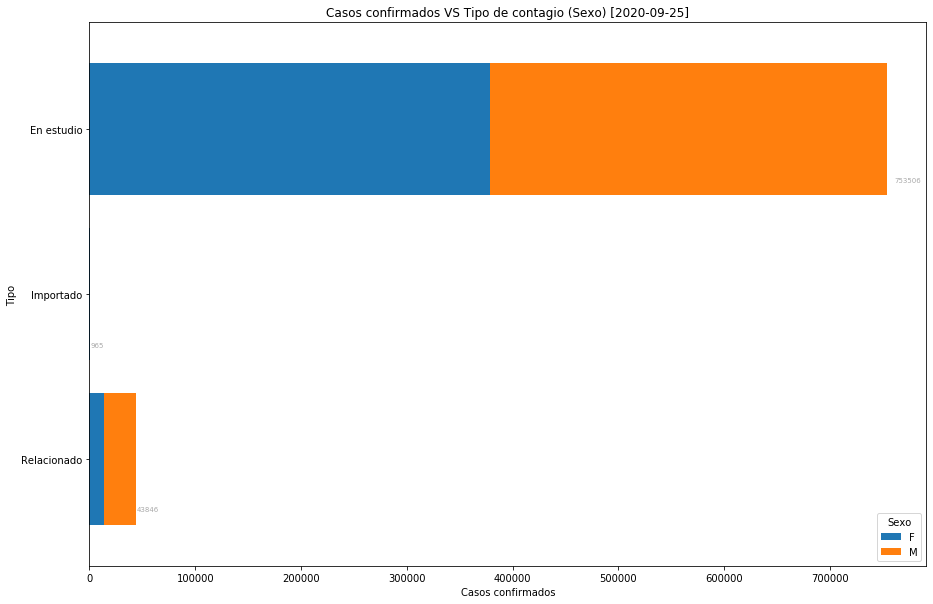

In [38]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [39]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   378406  375100
Importado       453     512
Relacionado   13707   30139

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

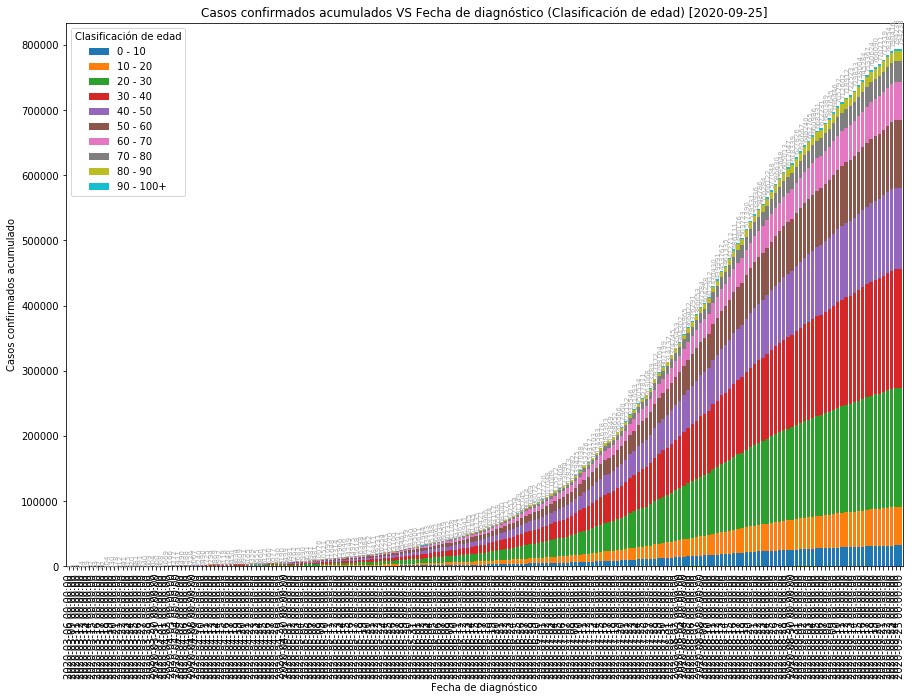

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-25              32048    58932   182235   182184   125488   103122   
2020-09-24              32048    58932   182235   182183   125488   103122   
2020-09-23              31896    58660   181415   181353   124923   102632   
2020-09-22              31655    58168   179932   179830   123940   101768   
2020-09-21              31381    57664   178426   178427   122987   100958   
2020-09-20              31141    57133   176761   176851   121878   100034   
2020-09-19              30976    56846   175876   175948   121228    99483   
2020-09-18              30760    56401   174633   174770   120417    98745   
2020-09-17              30481    55872   173017   173070   119300    97790   
2020-09-16              30211    55302   171080   171235   118056    96673   
2020-09-15              29919    54788   169411   169580   116887    95702   
2020-09-14              29622    54110   167603   167672   115562    94678   
2020-09-13              29339    53588   165929   165932   114392    93753   
2020-09-12              29204    53348   165059   165070   113843    93287   
2020-09-11              28949    52777   163600   163703   112835    92506   
2020-09-10              28723    52350   162436   162153   111584    91411   
2020-09-09              28342    51628   160052   159936   110258    90282   
2020-09-08              28027    50989   157958   157811   108871    89138   
2020-09-07              27766    50454   156316   156151   107748    88215   
2020-09-06              27459    49851   154478   154340   106425    87142   
2020-09-05              27321    49575   153617   153442   105805    86655   
2020-09-04              27047    48919   151923   151766   104667    85756   
2020-09-03              26721    48394   150005   149892   103377    84665   
2020-09-02              26486    47909   148465   148422   102327    83792   
2020-09-01              26102    47258   146325   146291   100835    82531   
2020-08-31              25757    46563   144281   144272    99468    81372   
2020-08-30              25335    45848   142010   142159    97962    80203   
2020-08-29              25090    45375   140525   140738    96972    79400   
2020-08-28              24835    44843   138883   139194    95873    78443   
2020-08-27              24508    44214   136784   136992    94393    77182   
2020-08-26              24150    43561   134685   134930    92948    76022   
2020-08-25              23797    42843   132618   132748    91402    74820   
2020-08-24              23401    42132   130141   130177    89636    73361   
2020-08-23              23034    41411   127862   127955    88090    72088   
2020-08-22              22723    40803   126077   126213    86979    71099   
2020-08-21              22400    40141   124038   124110    85644    69977   
2020-08-20              21975    39389   121567   121741    83999    68613   
2020-08-19              21488    38527   118899   119015    82073    66992   
2020-08-18              20856    37527   115826   115969    79824    65256   
2020-08-17              20601    37012   114148   114264    78620    64222   
2020-08-16              20085    36248   111917   112144    77013    62873   
2020-08-15              19466    35104   108938   109229    74878    61105   
2020-08-14              18965    34264   106322   106718    73081    59576   
2020-08-13              18711    33720   104587   105036    71861    58509   
2020-08-12              18086    32652   101472   101915    69661    56691   
2020-08-11              17738    32013    99378    99705    68145    55420   
2020-08-10              16928    30747    95243    95656    65306    53168   
2020-08-09              16598    30063    93290    93649    63949    52053   
2020-08-08              16351    29626    91756    92193    62846    51154   
2020-08-07            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

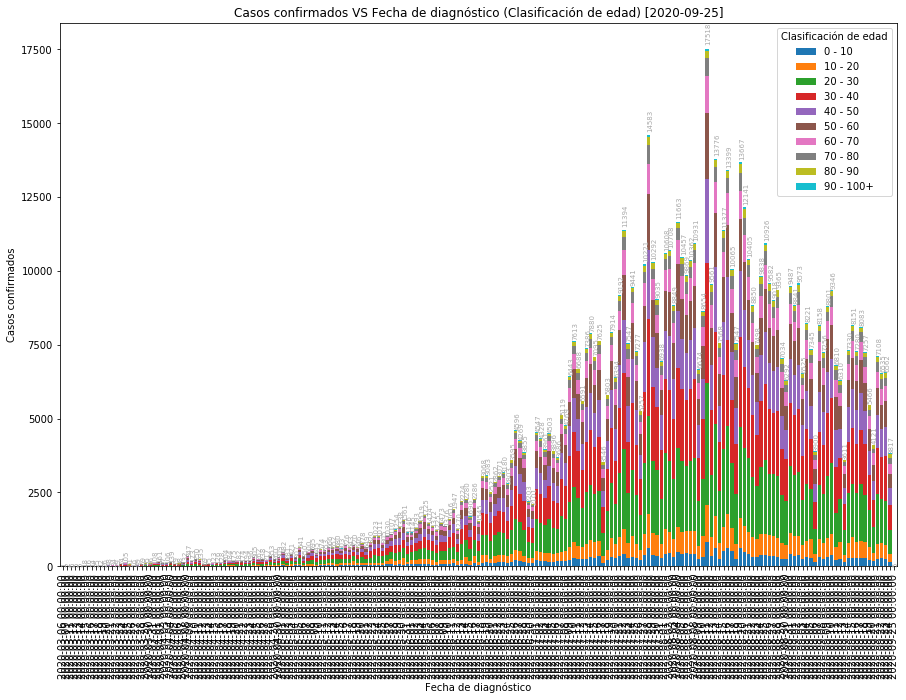

In [42]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [43]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-09-25                  0        0        0        1        0        0   
2020-09-24                152      272      820      830      565      490   
2020-09-23                241      492     1483     1523      983      864   
2020-09-22                274      504     1506     1403      953      810   
2020-09-21                240      531     1665     1576     1109      924   
2020-09-20                165      287      885      903      650      551   
2020-09-19                216      445     1243     1178      811      738   
2020-09-18                279      529     1616     1700     1117      955   
2020-09-17                270      570     1937     1835     1244     1117   
2020-09-16                292      514     1669     1655     1169      971   
2020-09-15                297      678     1808     1908     1325     1024   
2020-09-14                283      522     1674     1740     1170      925   
2020-09-13                135      240      870      862      549      466   
2020-09-12                255      571     1459     1367     1008      781   
2020-09-11                226      427     1164     1550     1251     1095   
2020-09-10                381      722     2384     2217     1326     1129   
2020-09-09                315      639     2094     2125     1387     1144   
2020-09-08                261      535     1642     1660     1123      923   
2020-09-07                307      603     1838     1811     1323     1073   
2020-09-06                138      276      861      898      620      487   
2020-09-05                274      656     1694     1676     1138      899   
2020-09-04                326      525     1918     1874     1290     1091   
2020-09-03                235      485     1540     1470     1050      873   
2020-09-02                384      651     2140     2131     1492     1261   
2020-09-01                345      695     2044     2019     1367     1159   
2020-08-31                422      715     2271     2113     1506     1169   
2020-08-30                245      473     1485     1421      990      803   
2020-08-29                255      532     1642     1544     1099      957   
2020-08-28                327      629     2099     2202     1480     1261   
2020-08-27                358      653     2099     2062     1445     1160   
2020-08-26                353      718     2067     2182     1546     1202   
2020-08-25                396      711     2477     2571     1766     1459   
2020-08-24                367      721     2279     2222     1546     1273   
2020-08-23                311      608     1785     1742     1111      989   
2020-08-22                323      662     2039     2103     1335     1122   
2020-08-21                425      752     2471     2369     1645     1364   
2020-08-20                487      862     2668     2726     1926     1621   
2020-08-19                632     1000     3073     3046     2249     1736   
2020-08-18                255      515     1678     1705     1204     1034   
2020-08-17                516      764     2231     2120     1607     1349   
2020-08-16                619     1144     2979     2915     2135     1768   
2020-08-15                501      840     2616     2511     1797     1529   
2020-08-14                254      544     1735     1682     1220     1067   
2020-08-13                625     1068     3115     3121     2200     1818   
2020-08-12                348      639     2094     2210     1516     1271   
2020-08-11                810     1266     4135     4049     2839     2252   
2020-08-10                330      684     1953     2007     1357     1115   
2020-08-09                247      437     1534     1456     1103      899   
2020-08-08                421      789     2463     2664     1719     1437   
2020-08-07            

### - Casos confirmados VS Estado (Clasificación de edad)

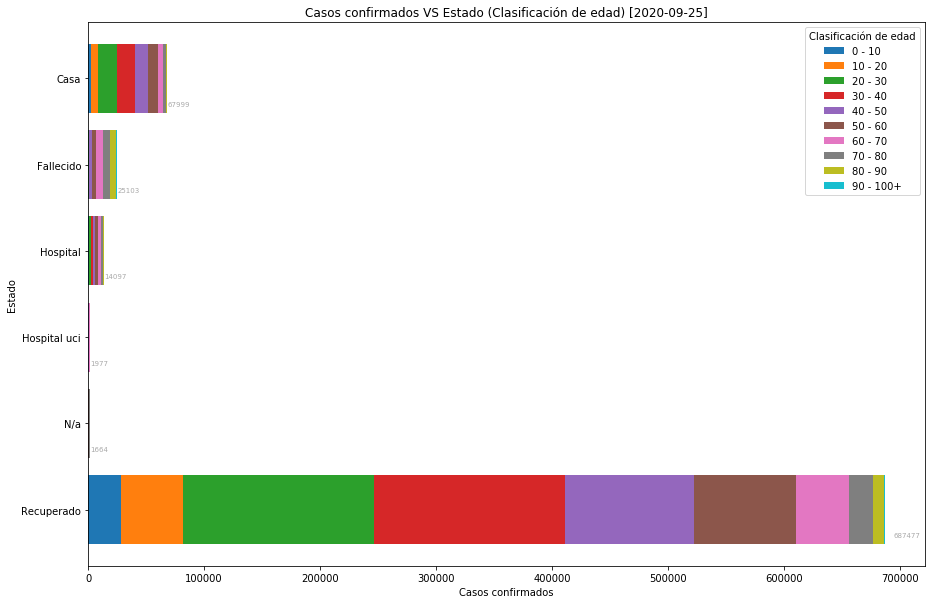

In [44]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     2777     5440    16525    16015    10671     8612   
Fallecido                  41       44      316      800     1764     3706   
Hospital                  699      388     1150     1616     1887     2696   
Hospital uci               51       16       76      181      266      480   
N/a                        38       32       68       65      120      198   
Recuperado              28583    53304   165097   164496   111380    87925   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      4541     2228     1010        180  
Fallecido                 6004     6489     4841       1098  
Hospital                  2650     1912      961        138  
Hospital uci               481      311      106          9  
N/a                        364      384      322         73  
Recuperado               45290    21243     8698       1461

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

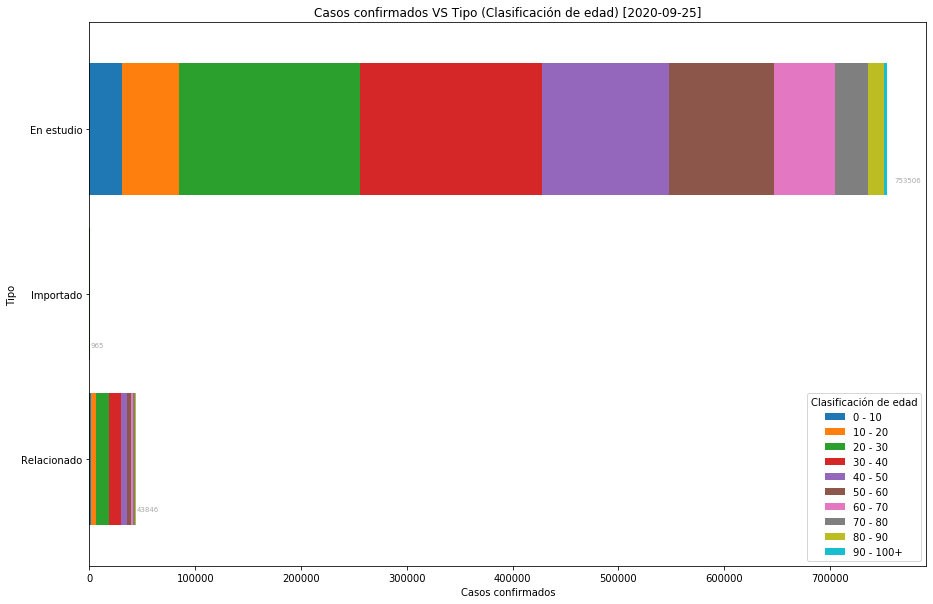

In [46]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [47]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              30820    54095   170953   171653   120334    99540   
Importado                   7       34      240      225      168      146   
Relacionado              1362     5095    12039    11295     5586     3931   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               57099    31315    15005       2692  
Importado                   97       37       10          1  
Relacionado               2134     1215      923        266

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [48]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)